### Loading Quantinuum Hardware


In [1]:
#%pip install pytket

In [2]:
from pytket.extensions.quantinuum import QuantinuumBackend

machine = 'H1-1'

backend = QuantinuumBackend(device_name = machine)
backend.login()

In [3]:
print(machine, "status: ", QuantinuumBackend.device_state(device_name = machine))

H1-1 status:  in maintenance


List all the available devices

In [4]:
[x.device_name for x in QuantinuumBackend.available_devices()]

['H1-1SC', 'H1-1E', 'H1-1']

#### How to change the backend?

In [5]:
machine = 'H1-1E'
n_shots = 100
max_batch_cost = 100

backend = QuantinuumBackend(device_name = machine)

### Quantinuum TKET Workshop

#### Introduction to Quantum Software and TKET


 System Software
<li> Compiler  - TKET , Qiskit
<li> Online Service - AWS Braket, Azure quantum
<li> Quantum Error Correction - Qermit
<li> Quantum Programming Language - Q#, Silq, quipper

Quantum Hardware

<li> Trapped Ions - Quantinuum, IONQ, AQT
<li> Superconductors - IBM, Google , Rigetti, IQM
<li> Photonics - PsiQuantum, Quandela
<li> Neutral Atoms - Pasqal, Infleqtion
<li> Others - Semiconductors, Topological Qubits

In [6]:
import warnings
warnings.filterwarnings("ignore")

## Making the circuit

Let's build a basic **Bell Circuit**

First we'll make the circuit and then add the gates sequentially.



In [7]:
from pytket import Circuit, OpType
from pytket.circuit.display import render_circuit_jupyter # necessary to visualize circuits in Jupyter

In [8]:
# let's create a Bell state
Bell = Circuit(2, 2, name="Bell")
Bell.H(0) # Hadamard gate on qubit 0
Bell.CX(0, 1) # CNOT gate on control qubit 0 and target qubit 1
render_circuit_jupyter(Bell) # visualize the circuit

Let's run it on `AerStateBackend`

In [9]:
from pytket.extensions.qiskit import AerStateBackend # import the backend to simulate the circuit

sv_backend = AerStateBackend() # initialize the backend
sv_result = sv_backend.run_circuit(Bell,n_shots= 100).get_state() # run the circuit

print("The statevector is :",sv_result) # print the statevector

The statevector is : [0.70710678+0.j 0.        +0.j 0.        +0.j 0.70710678+0.j]


which is basically this 

$ \begin{equation}
|\psi \rangle = \frac{1}{\sqrt{2}} \big(|00 \rangle + | 11 \rangle  \big)\,, \qquad \frac{1}{\sqrt{2}} \approx 0.707...
\end{equation}$

Let's see the counts

In [10]:
from pytket.extensions.qiskit import AerBackend # import the backend to simulate the circuit

# we need to measure first
Bell.measure_all()
render_circuit_jupyter(Bell) # visualize the circuit


backend = AerBackend() # initialize the backend
result = backend.run_circuit(Bell,n_shots= 100).get_counts() # run the circuit
print("The result is :",result) # print the result

The result is : Counter({(0, 0): 52, (1, 1): 48})


#### Plotting

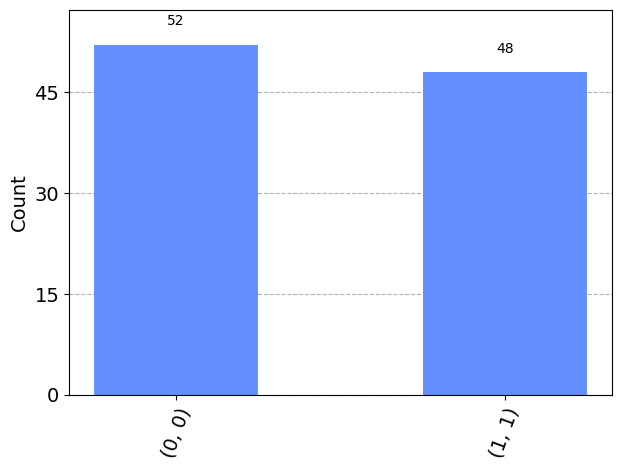

In [11]:
# from plotting import plot_results # import the function to plot the results 
'''
plot_results do not work from plotting, so use plot_histogram from qiskit.tools.visualization

'''
from qiskit.tools.visualization import plot_histogram
plot_histogram(result) # plot the results

Adding simple gates is easy in `pytket`, but somegates need to be accessed through teh `OpType`, where angles are specified as the number of half turns.

>All parametrised OpTypes which take angles (e.g. Rz, CPhase, FSim) expect parameters in multiples of pi (half-turns). This may differ from other quantum programming tools you have used, which have specified angles in radians, or perhaps even degrees. Therefore, for instance circuit.add_gate(OpType.Rx, 1, [0]) is equivalent in terms of the unitary to circuit.add_gate(OpType.X, [0])

Let's learn about this by making a **Quantum Fourier Transform Circuit**

This circuit is a very important subroutine in many algorithms including **Shor's algorithms**



To make an $n$ qubit QFT, we need $n$ Hadamard gate (one for each qubit), $n/2$ SWAP gates, and a $n(n-1)/2$ controlled unitary rotations
 $$ \begin{equation}
\text{CU1} = 
\begin{pmatrix}
I & 0 \\
0 & \text{U1}
\end{pmatrix}
\,, \quad 
\text{U1} = 
\begin{pmatrix}
1 & 0 \\
0 & e^{i \pi \theta}
\end{pmatrix}
\end{equation}$$


rotation is done by smaller and smaller angles of $\theta = \frac{1}{2^{n-1}}$

In [12]:
# let's build a QFT circuit for 3 qubits

from pytket.circuit import Qubit, Bit, Circuit, OpType

qft = Circuit(3, name="QFT")

# add the hadamard, which is done simply
qft.H(0)
## adding the controlled rotations is a bit more involved

qft.add_gate(OpType.CU1, [0.5],[1,0])

# circuit.add_gate(OpType.gate, [number of rotations], [control qubit, target qubit])
qft.add_gate(OpType.CU1, [0.25],[2,0])

# another one

qft.H(1)
qft.add_gate(OpType.CU1,[0.5],[2,1])
qft.H(2)

# and a final swap

qft.SWAP(0,2)

# let's see what we have

render_circuit_jupyter(qft)

Let's build a **QFT** Circuit for `n` qubits

In [13]:
def qft_circuit(n):
    qft = Circuit(n, name="QFT")
    for i in range(n):
        qft.H(i)
        for j in range(i+1,n):
            qft.add_gate(OpType.CU1, [2**-(j-i)],[j,i])
    for i in range(n//2):
        qft.SWAP(i,n-i-1)
    return qft

In [14]:
render_circuit_jupyter(qft_circuit(4))

### Circuit Boxes

<li> Raw Quantum gates are sometimes too low level to see what's going on
<li> We can wrap subcircuits into boxes and add them to circuits, which is useful for subroutines

Let's see an example via Grover's algorithm

In [15]:
# grover
oracle = Circuit(4,name="Oracle")

oracle.X(0).X(1).X(2).X(3)
oracle.add_gate(OpType.CnZ,[0,1,2,3])
# circuit.add_gate(OpType.gate, [control qubits[i] ,target qubit])
oracle.X(0).X(1).X(2).X(3)

render_circuit_jupyter(oracle)

Let's make it a box

In [16]:
from pytket.circuit import CircBox

oracle_in_a_box = CircBox(oracle)

# another circuit
circ = Circuit(4)
circ.H(0).H(1).H(2).H(3) # all qubits in superposition
circ.add_circbox(oracle_in_a_box,[0,1,2,3])

render_circuit_jupyter(circ)

### Circuit Boxes Returns

Often we need to synthesise a quantum circuit to implement a given unitary, this is supoorted for up to $3$ qubits by TKET. A two qubit unitary can be implemented with at most $3$ **CX** gates.

Let's see an example with the Fermionic SWAP or the FSWAP gate:

$$ \begin{equation}
\text{FSWAP} =
\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0\\
0 & 0 & 0 & -1 
\end{pmatrix}
\end{equation}$$

In [17]:
from pytket.circuit import Unitary2qBox
import numpy as np
unitary_2q = np.asarray([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])

u2_box = Unitary2qBox(unitary_2q)

# make a new circuit
circ1 = Circuit(2)
circ1.add_unitary2qbox(u2_box,0,1)

render_circuit_jupyter(circ1)

Let's see what's inside this box

In [18]:
from pytket.passes import DecomposeBoxes
DecomposeBoxes().apply(circ1)
render_circuit_jupyter(circ1)

### Constructing Circuit from QASM
Open Quantum Assembly langauge provides a low level specifications of the quantum circuit. We can easily build a circuit from QASM and make a circuit to QASM as well. 

We have this `qpe.qasm` file already with us, let's try and build it

In [19]:
from pytket.qasm import circuit_from_qasm

qpe_circ = circuit_from_qasm("qpe.qasm")

print("total number of gates:",qpe_circ.n_gates)    

print("number of qubits:",qpe_circ.n_qubits)

print("number of bits:",qpe_circ.n_bits)

print("number of two qubit gates: ", qpe_circ.n_2qb_gates())

render_circuit_jupyter(qpe_circ)

total number of gates: 21
number of qubits: 4
number of bits: 3
number of two qubit gates:  11


### Using Quantum Devices and Simulators



In [20]:
# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

In [53]:
from pytket.extensions.qiskit import IBMQEmulatorBackend
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise.noise_model import NoiseModel
from pytket.qasm import circuit_from_qasm

qpe5_circ = circuit_from_qasm("qpe5.qasm")
noisy_backend = IBMQEmulatorBackend('ibmq_kolkata')


kolkata_noise_model = NoiseModel.from_backend(noisy_backend._ibmq._backend)

In [54]:
noisy_aer_backend = AerBackend(kolkata_noise_model)

render_circuit_jupyter(qpe5_circ)

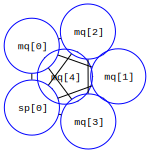

In [55]:
from pytket.utils import Graph

Graph(qpe5_circ).get_qubit_graph()

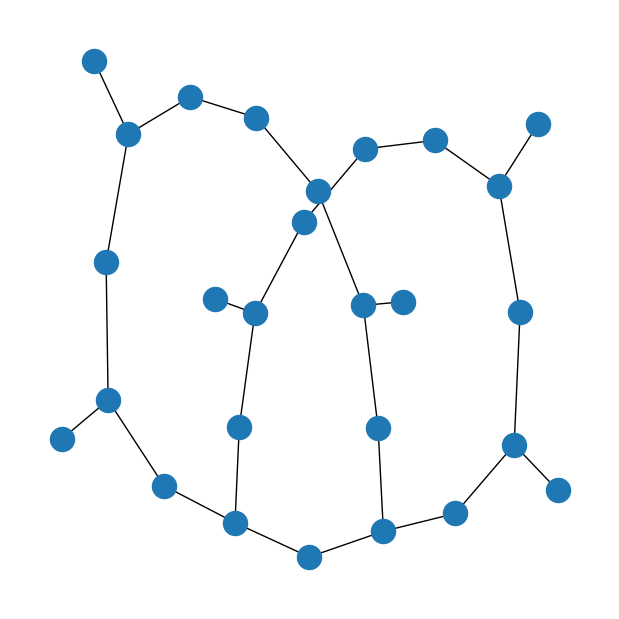

In [56]:


import networkx as nx
import matplotlib.pyplot as plt

coupling_graph = noisy_aer_backend.backend_info.architecture.coupling
G = nx.Graph(coupling_graph)
plt.figure(figsize=(6,6))
nx.draw(G)
plt.show()



In [57]:


compiled_circuit_l0 = noisy_aer_backend.get_compiled_circuit(qpe5_circ, optimisation_level=0)

cx_count = compiled_circuit_l0.n_2qb_gates()
print("How many CX gates do we have originally?" ,cx_count)



How many CX gates do we have originally? 133


In [58]:
render_circuit_jupyter(compiled_circuit_l0)


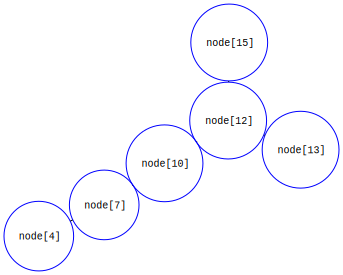

In [59]:
Graph(compiled_circuit_l0).get_qubit_graph()

In [60]:
handlel0 = noisy_aer_backend.process_circuit(compiled_circuit_l0, n_shots=1000)
resultl0 = noisy_aer_backend.get_result(handlel0)

In [61]:


print(resultl0.get_counts().most_common()[0])



((0, 1, 1, 0, 1), 284)


In [62]:


compiled_qft = noisy_backend.get_compiled_circuit(qft)

render_circuit_jupyter(compiled_qft)



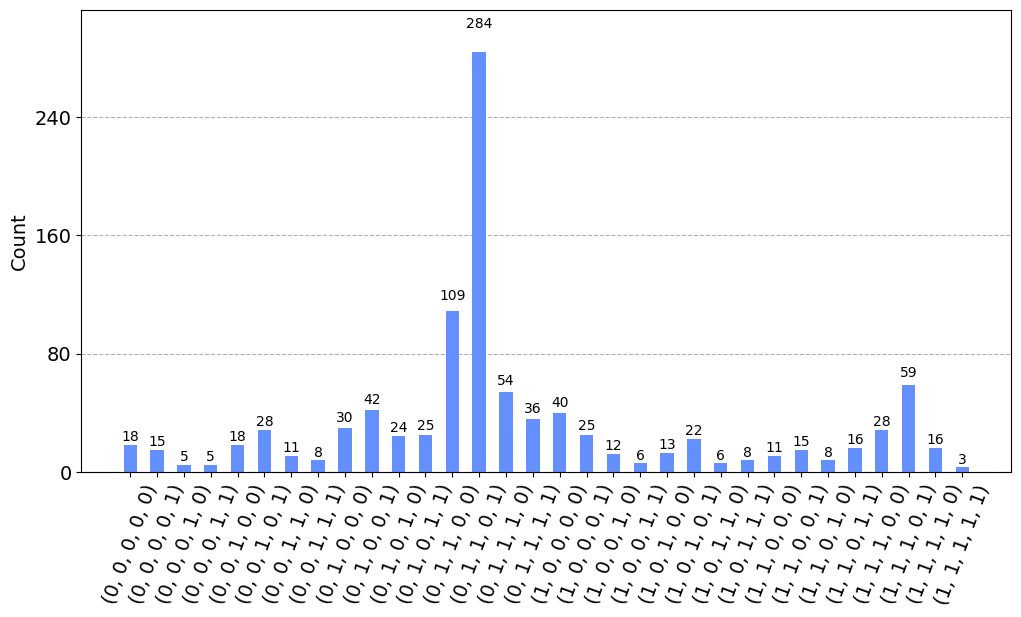

In [63]:
plot_histogram(resultl0.get_counts(),bar_labels=True,figsize=(12, 6))

For Optimization Level 1

In [64]:
compiled_circuit_l1 = noisy_backend.get_compiled_circuit(qpe5_circ, optimisation_level=1)
cx_count = compiled_circuit_l1.n_gates_of_type(OpType.CX)
print(f"Our optimised circuit for level 1 has {cx_count} CX gates")

handlel1 = noisy_aer_backend.process_circuit(compiled_circuit_l1, n_shots=1000)
resultl1 = noisy_aer_backend.get_result(handlel1)

Our optimised circuit for level 1 has 127 CX gates


In [65]:


print(resultl1.get_counts().most_common()[0])



((0, 1, 1, 0, 1), 318)


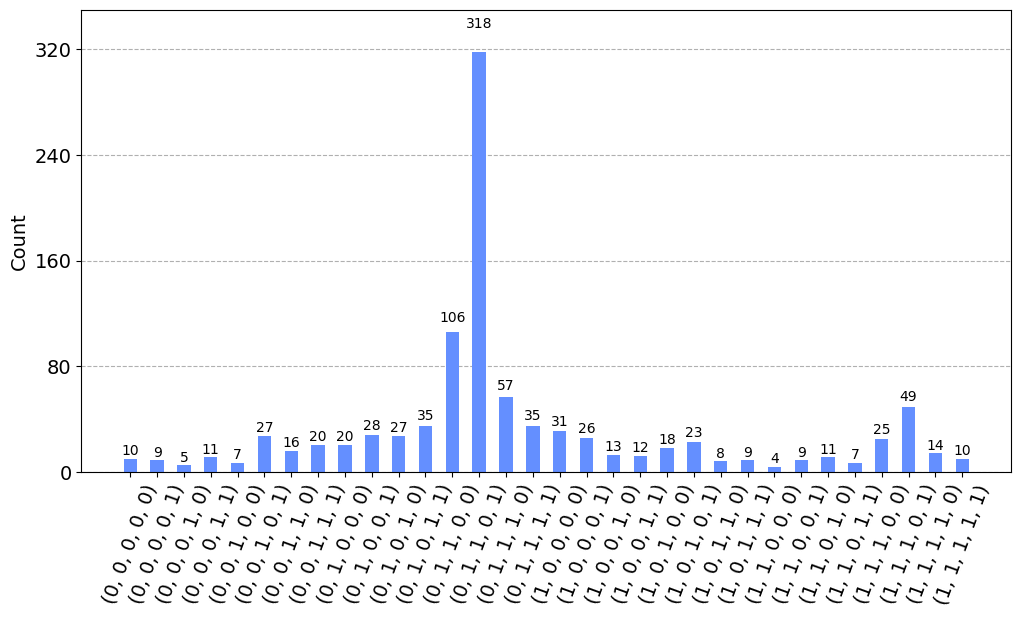

In [66]:
plot_histogram(resultl1.get_counts(),bar_labels=True,figsize=(12, 6))

In [67]:
compiled_circuit_l2 = noisy_backend.get_compiled_circuit(qpe5_circ, optimisation_level=2)
cx_count = compiled_circuit_l2.n_gates_of_type(OpType.CX)
print(f"Our optimised circuit for Level 2 has {cx_count} CX gates")

handlel2 = noisy_aer_backend.process_circuit(compiled_circuit_l2, n_shots=1000)
resultl2 = noisy_aer_backend.get_result(handlel2)

Our optimised circuit for Level 2 has 58 CX gates


In [68]:

print(resultl2.get_counts().most_common()[0])


((0, 1, 1, 0, 1), 540)


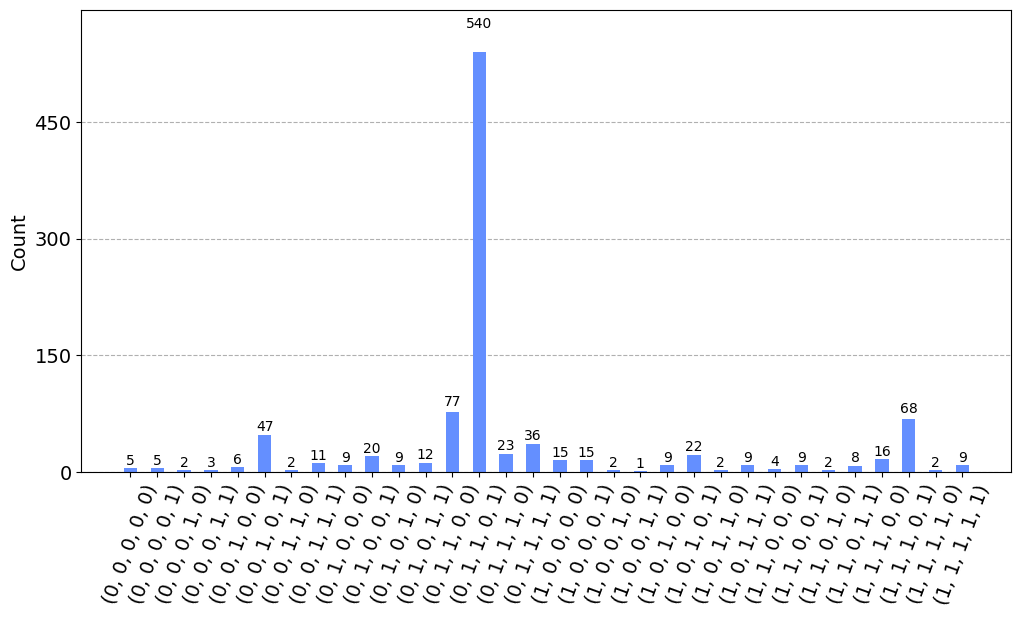

In [69]:
plot_histogram(resultl2.get_counts(),bar_labels=True,figsize=(12, 6))

### Switching Backends in pytket

We want to run out quantum algorithms on different devices, let's switch to different simulators first. Let's try with `cirq`

In [71]:
# switching to cirq
from pytket.extensions.cirq import CirqStateSampleBackend

cirq_backend = CirqStateSampleBackend()
compiled_cirq = cirq_backend.get_compiled_circuit(qpe_circ)

render_circuit_jupyter(compiled_cirq)

cirq_result = cirq_backend.run_circuit(compiled_cirq,n_shots=1000).get_counts()
print(cirq_result)

Counter({(0, 0, 1): 1000})


### Optimization passes

We can see from the phase estimation circuits, that we can boost the fidelity by reducing the number of gates in our circuit. Let's try something from Quantum Chemistry poit of view and use `FullPeephileOptimise` pass


In [72]:
# load the circuit from the qasm file
jw_chem_circ = circuit_from_qasm("H2JordanWignerMapper.qasm")

# let's see how it looks
render_circuit_jupyter(jw_chem_circ)

# see the number of gates
print("total number of gates:",jw_chem_circ.n_gates)
print("number of qubits:",jw_chem_circ.n_qubits)
print("number of bits:",jw_chem_circ.n_bits)
print("number of two qubit gates: ", jw_chem_circ.n_2qb_gates())

total number of gates: 150
number of qubits: 4
number of bits: 0
number of two qubit gates:  56


Let's apply the optimization

In [73]:
from pytket.passes import FullPeepholeOptimise

FullPeepholeOptimise().apply(jw_chem_circ)
render_circuit_jupyter(jw_chem_circ)

print("total number of gates:",jw_chem_circ.n_gates)
print("number of qubits:",jw_chem_circ.n_qubits)
print("number of bits:",jw_chem_circ.n_bits)
print("number of two qubit gates: ", jw_chem_circ.n_2qb_gates())

total number of gates: 46
number of qubits: 4
number of bits: 0
number of two qubit gates:  17


From $150$ gates earlier, we now have $46$ gates and $56$ two qubit gates earlier, we now have $17$ two qubit gates

In [74]:
from pytket.passes import auto_rebase_pass

ibm_gateset = {OpType.X, OpType.SX, OpType.Rz, OpType.CX}
ibm_rebase = auto_rebase_pass(ibm_gateset)

ibm_rebase.apply(jw_chem_circ)

True

The `auto_rebase_pass` works well if converting to a well known gateset, i.e the one used by IBM, Rebasing to other universal sets of 1qubit and 2 qubit gates can be accompolished via `RebaseCustom`

In [75]:
render_circuit_jupyter(jw_chem_circ)

We can make our own circuit transformations with `SequencePass`

In [76]:
from pytket.passes import SequencePass

seq_pass = SequencePass([FullPeepholeOptimise(),ibm_rebase])

jw_chem_circ = circuit_from_qasm("H2JordanWignerMapper.qasm")
seq_pass.apply(jw_chem_circ)
render_circuit_jupyter(jw_chem_circ)

### Working with Qiskit, Cirq and other libraries


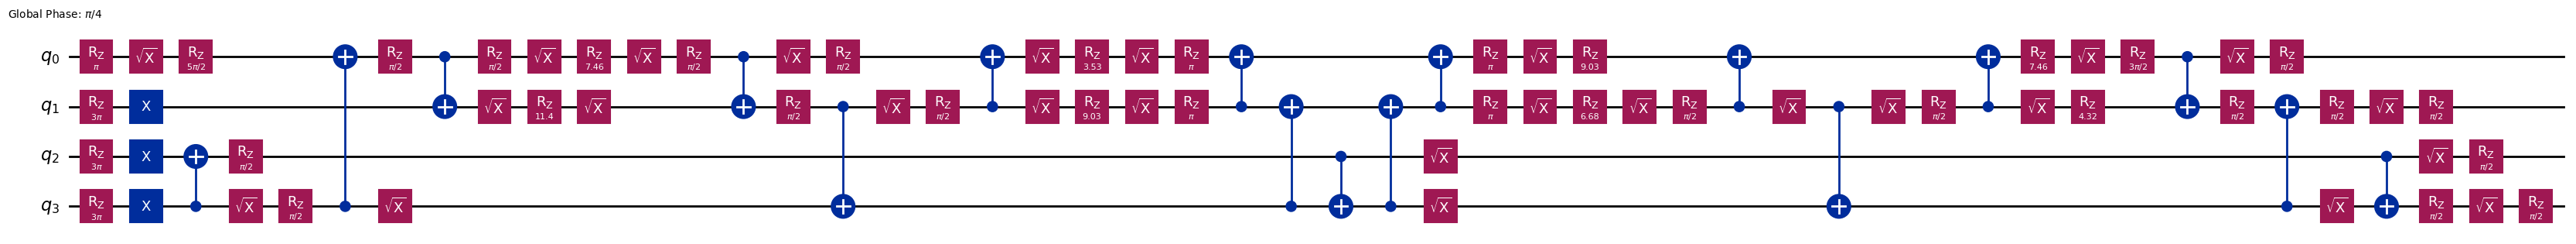

In [77]:
from pytket.extensions.qiskit import tk_to_qiskit

qiskit_circ = tk_to_qiskit(jw_chem_circ)

qiskit_circ.draw(output='mpl',style='iqx',fold=-1)



## Some New Features


### Arbitrary State Preparation

We can prepare an arbitrary state inpytker. The size of the circuit will scale exponentially with the number of qubits, Let's try and make the following state:

$$ \begin{equation}
    |W\rangle = \frac{1}{\sqrt{3}} \big(|001\rangle + |010\rangle + |100\rangle \big)
\end{equation}$$

In [78]:
from pytket.circuit import StatePreparationBox

werner_state = 1/ np.sqrt(3) * np.array([0,1,1,0,1,0,0,0])

werner_state_box = StatePreparationBox(werner_state)

state_circ = Circuit(3)

state_circ.add_gate(werner_state_box, [0,1,2])

[StatePreparationBox q[0], q[1], q[2]; ]

In [79]:
render_circuit_jupyter(state_circ)

### Toffoli Box

A type of `Circuit` box that can implement an arbitrary permutation of computational basis state

$$ \begin{gather}
    |001\rangle \longmapsto |111\rangle \\
    |111\rangle \longmapsto |001\rangle \\
    |100\rangle \longmapsto |000\rangle \\
    |000\rangle \longmapsto |100\rangle
\end{gather}$$

In [80]:
from pytket.circuit import ToffoliBox

# Specify the desired permutation of the basis states
mapping = {
    (0, 0, 1): (1, 1, 1),
    (1, 1, 1): (0, 0, 1),
    (1, 0, 0): (0, 0, 0),
    (0, 0, 0): (1, 0, 0),
}

# Define box to perform the permutation
perm_box = ToffoliBox(permutation=mapping)

$ \begin{equation}
\frac{1}{\sqrt{3}} \big(|001\rangle + |010\rangle +|100\rangle \big)   \longmapsto \frac{1}{\sqrt{3}} \big(|000\rangle + |010\rangle + |111\rangle \big)
\end{equation}$